
# Customer Churn Prediction

This notebook demonstrates how to build a **supervised machine learning model** to predict customer churn, 
an online food ordering provider.

**Why churn prediction matters?**
- Acquiring a new customer is 5–7 times more expensive than retaining an existing one.
- By predicting churn, can target discounts, loyalty campaigns, or personalized offers to customers **before they leave**.


## Step 1: Import Libraries

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

## Step 2: Create Sample Dataset

In [2]:

# Simulated dataset 
np.random.seed(42)
n = 10000

data = pd.DataFrame({
    'customer_id': range(1, n+1),
    'last_order_days_ago': np.random.randint(1, 365, n),
    'total_orders': np.random.poisson(10, n),
    'avg_order_value': np.random.uniform(5, 50, n),
    'complaints': np.random.binomial(5, 0.1, n),
    'discount_used': np.random.randint(0, 20, n),
    'churn': np.random.binomial(1, 0.3, n)  # 1 = churned, 0 = active
})

data.head()


,customer_id,last_order_days_ago,total_orders,avg_order_value,complaints,discount_used,churn
0,1,103,10,38.251680,1,4,1
1,2,349,9,37.210404,0,13,1
2,3,271,9,36.023084,0,7,1
3,4,107,9,17.451155,0,10,0
4,5,72,9,30.801515,1,14,1


## Step 3: Exploratory Data Analysis

       customer_id  last_order_days_ago  total_orders  avg_order_value  \
count  10000.00000         10000.000000  10000.000000     10000.000000   
mean    5000.50000           181.922300     10.042600        27.451422   
std     2886.89568           104.853453      3.160472        13.000012   
min        1.00000             1.000000      0.000000         5.009142   
25%     2500.75000            93.000000      8.000000        16.280541   
50%     5000.50000           181.000000     10.000000        27.375755   
75%     7500.25000           273.000000     12.000000        38.774759   
max    10000.00000           364.000000     23.000000        49.995486   

         complaints  discount_used         churn  
count  10000.000000   10000.000000  10000.000000  
mean       0.499400       9.437900      0.305100  
std        0.668763       5.735227      0.460473  
min        0.000000       0.000000      0.000000  
25%        0.000000       4.000000      0.000000  
50%        0.000000       9

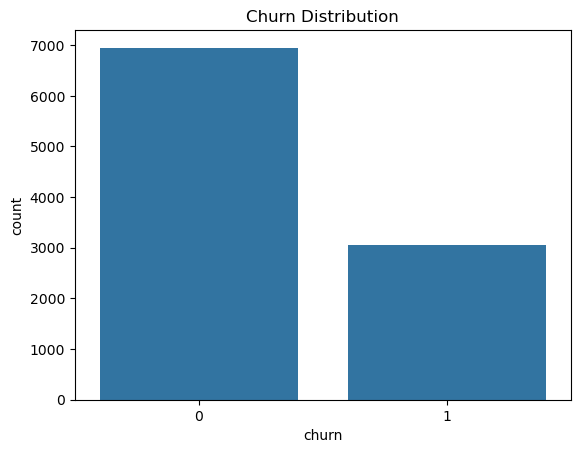

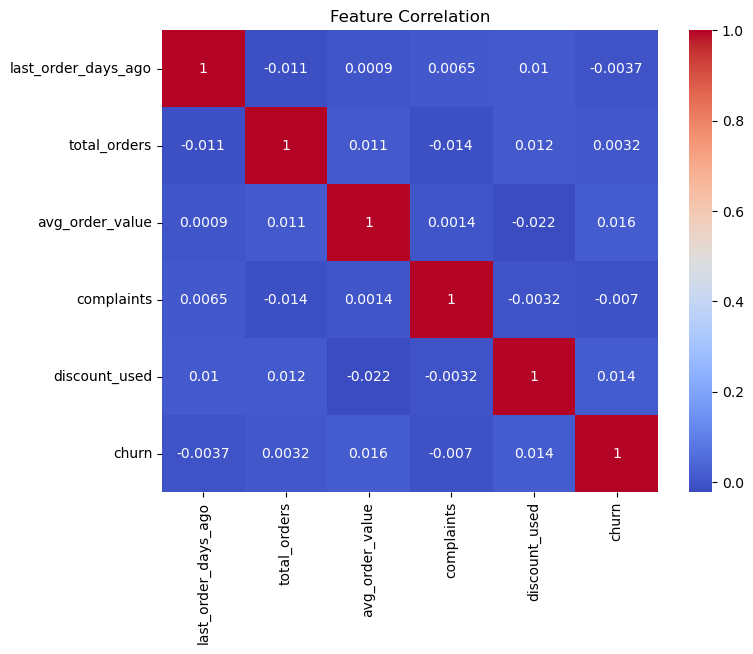

In [3]:

# Basic statistics
print(data.describe())

# Churn distribution
sns.countplot(x='churn', data=data)
plt.title("Churn Distribution")
plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(data.drop('customer_id', axis=1).corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()


## Step 4: Data Preprocessing

In [4]:

X = data.drop(['customer_id', 'churn'], axis=1)
y = data['churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Step 5: Train Models

In [5]:

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)


## Step 6: Model Evaluation

Logistic Regression:
               precision    recall  f1-score   support

           0       0.69      1.00      0.82      1390
           1       0.00      0.00      0.00       610

    accuracy                           0.69      2000
   macro avg       0.35      0.50      0.41      2000
weighted avg       0.48      0.69      0.57      2000

Random Forest:
               precision    recall  f1-score   support

           0       0.70      0.92      0.79      1390
           1       0.31      0.09      0.13       610

    accuracy                           0.66      2000
   macro avg       0.50      0.50      0.46      2000
weighted avg       0.58      0.66      0.59      2000

XGBoost:
               precision    recall  f1-score   support

           0       0.70      0.89      0.78      1390
           1       0.32      0.12      0.17       610

    accuracy                           0.66      2000
   macro avg       0.51      0.50      0.48      2000
weighted avg       0.58   

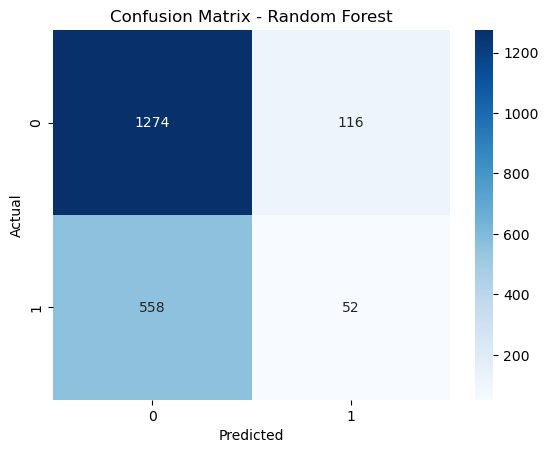

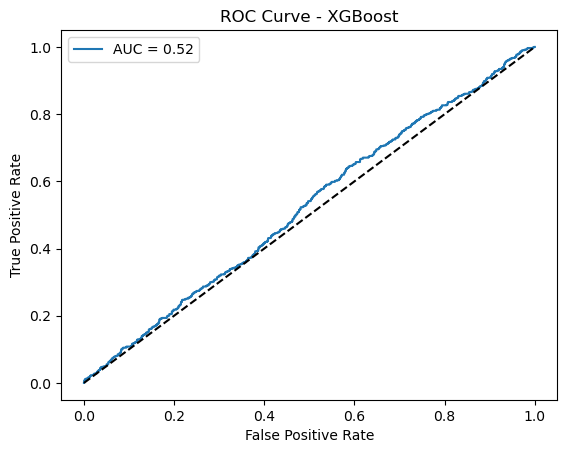

In [6]:

print("Logistic Regression:\n", classification_report(y_test, y_pred_log))
print("Random Forest:\n", classification_report(y_test, y_pred_rf))
print("XGBoost:\n", classification_report(y_test, y_pred_xgb))

# Confusion Matrix for Random Forest
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve for XGBoost
y_probs = xgb.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_probs):.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.show()


In [7]:
ex_data = [186, 8, 25.8733, 2, 11]

# Convert to numpy array and reshape to (1, n_features)
ex_data = np.array(ex_data).reshape(1, -1)

# Preprocessing by Standard Scaler
ex_data_scaled = scaler.transform(ex_data)

# Prediction By Algorithms:
ex_data_pred_log = log_reg.predict(ex_data_scaled)
ex_data_pred_rf = rf.predict(ex_data_scaled)
ex_data_pred_xgb = xgb.predict(ex_data_scaled)

print(f'Prediction by Logistic Regression is {ex_data_pred_log[0]}')
print(f'Prediction by Random Forest is {ex_data_pred_rf[0]}')
print(f'Prediction by XGBoost is {ex_data_pred_xgb[0]}')


Prediction by Logistic Regression is 0
Prediction by Random Forest is 1
Prediction by XGBoost is 0


In [8]:
ex_data = [1, 1, 95.5, 0, 2]

# Convert to numpy array and reshape to (1, n_features)
ex_data = np.array(ex_data).reshape(1, -1)

# Preprocessing by Standard Scaler
ex_data_scaled = scaler.transform(ex_data)

# Prediction By Algorithms:
ex_data_pred_log = log_reg.predict(ex_data_scaled)
ex_data_pred_rf = rf.predict(ex_data_scaled)
ex_data_pred_xgb = xgb.predict(ex_data_scaled)

print(f'Prediction by Logistic Regression is {ex_data_pred_log[0]}')
print(f'Prediction by Random Forest is {ex_data_pred_rf[0]}')
print(f'Prediction by XGBoost is {ex_data_pred_xgb[0]}')


Prediction by Logistic Regression is 0
Prediction by Random Forest is 0
Prediction by XGBoost is 0


## Step 7: Feature Importance

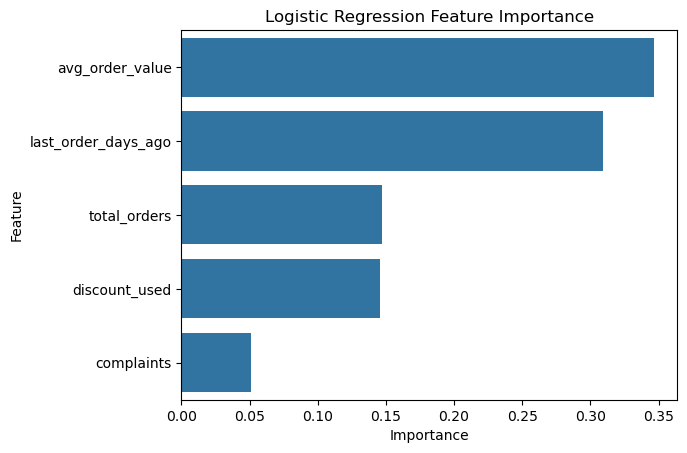

In [9]:

importances = rf.feature_importances_
feat_names = X.columns

feat_imp = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)

sns.barplot(x='Importance', y='Feature', data=feat_imp)
plt.title("Logistic Regression Feature Importance")
plt.show()



## Step 8: Conclusion & Business Use Case

- The models give us a way to predict which customers are likely to churn.  
- We can integrate this model into the CRM/marketing system:  
  - Send targeted discounts to **high-risk churners**.  
  - Recommend personalized meals to re-engage customers.  
  - Monitor churn rates across restaurants and regions.  

**Next Steps:**
- Replace synthetic dataset with real customer order data.  
- Regularly retrain the model with new data.  
- Deploy as an API to integrate with the app.  
